In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler


In [ ]:
#import MNIST dataset from torchvision
train_data = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

#split the training dataset into training and validation dataset using random stratified sampling
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size])

#load the datasets into dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, )
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
#check dimensions of the data in train_dataset
for data, target in train_loader:
    print(data.shape)
    print(target.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


## Visualize 5 different digits

Random images from digit 7:


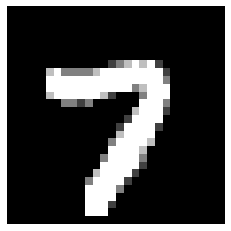

Random images from digit 1:


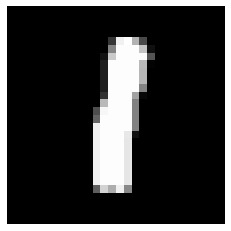

Random images from digit 9:


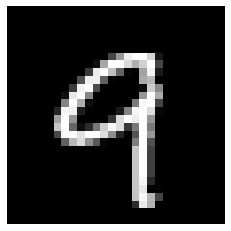

Random images from digit 2:


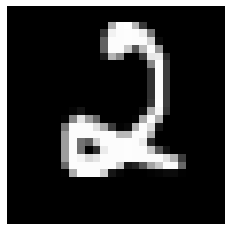

Random images from digit 4:


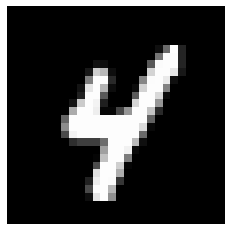

In [ ]:



# Define a function to plot images from the dataset
def plot_images(images):
    grid = torchvision.utils.make_grid(images, nrow=5)

    # Convert the grid to a numpy array and transpose the dimensions to match matplotlib's expectations
    grid = grid.permute(1, 2, 0).numpy()

    # Show the grid of images
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.show()

# Choose 5 random digits and load a batch of images for each digit
digits = np.random.choice(10, size=5, replace=False)
images = []
for digit in digits:
    digit_indices = (train_data.targets == digit).nonzero(as_tuple=False).squeeze()
    random_indices = torch.randperm(digit_indices.numel())[:5]
    digit_images = train_data.data[digit_indices[random_indices]]
    images.append(digit_images)

# print(digits)
# Plot the images for each digit
for digit, digit_images in zip(digits, images):
    print(f"Random images from digit {digit}:")
    plot_images(digit_images[0])


# CNN Model

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'train_loss': loss, 'train_acc': acc}

        # return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
#Building the CNN model
class CNN(ImageClassificationBase):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 5)
        self.conv2 = nn.Conv2d(in_channels = 10, out_channels = 20, kernel_size = 2)
        self.fc1 = nn.Linear(500, 50)
        # self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)

        x = F.relu(x)
        x = F.max_pool2d(x, 2) # defualt stride =  kernal size so 2 here


        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)
        # x = self.dropout2(x)
        # x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
# @torch.no_grad()
# labels.requires_grad_(True)
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            train = model.training_step(batch)
            loss = train['train_loss']
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        print(train['train_acc'])
        result['train_acc'] = train['train_acc'].item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
num_epochs = 50
opt_func = torch.optim.Adam
lr = 0.001
model = CNN()
model



CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
#function to add model on GPU 
device = get_default_device()

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
print(device)

cuda


## adding model and data to gpu

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([7, 8, 5, 4, 9, 3, 1, 6, 8, 9, 2, 1, 7, 2, 7, 5, 5, 7, 1, 3, 4, 4, 8, 0,
        1, 8, 9, 0, 9, 4, 1, 5, 8, 9, 8, 9, 7, 9, 3, 8, 1, 1, 5, 4, 3, 4, 2, 9,
        0, 0, 1, 8, 2, 9, 0, 5, 6, 2, 9, 7, 7, 7, 5, 7], device='cuda:0')


In [ ]:

to_device(model, device)

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
)

# Running model


In [ ]:
history = fit(10, lr, model, train_loader, val_loader, opt_func)

## setup 1 Accuracy , loss plot

In [ ]:
def plot_accuracies(history):
    accuracies_val = [x['val_acc'] for x in history]
    accuracies_train = [x['train_acc'] for x in history]

    plt.plot(accuracies_val, '-x', label='val')
    plt.plot(accuracies_train, '-x',  label='train')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    
    plt.title('Accuracy vs. No. of epochs');

## loss curve 
def plot_loss(history):
    loss_val = [x['val_loss'] for x in history]
    loss_train = [x['train_loss'] for x in history]

    plt.plot(loss_val, '-x', label='val')
    plt.plot(loss_train, '-x',  label='train')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.title('LOSS vs. No. of epochs');



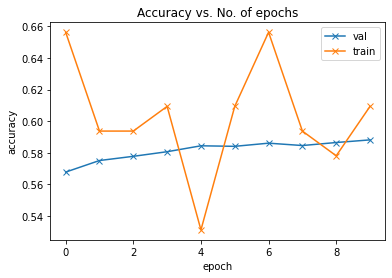

In [ ]:
plot_accuracies(history)

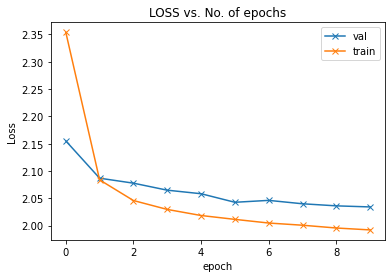

In [ ]:
plot_loss(history)

In [ ]:
history += fit(10, lr, model, train_loader, val_loader, opt_func)

tensor(0.6562)
Epoch [0], train_loss: 1.9892, train_acc: 0.6562, val_loss: 2.0319, val_acc: 0.5874
tensor(0.6094)
Epoch [1], train_loss: 1.9859, train_acc: 0.6094, val_loss: 2.0382, val_acc: 0.5881
tensor(0.5938)
Epoch [2], train_loss: 1.9842, train_acc: 0.5938, val_loss: 2.0375, val_acc: 0.5887
tensor(0.6406)
Epoch [3], train_loss: 1.9823, train_acc: 0.6406, val_loss: 2.0323, val_acc: 0.5888
tensor(0.5625)
Epoch [4], train_loss: 1.9796, train_acc: 0.5625, val_loss: 2.0282, val_acc: 0.5897
tensor(0.5625)
Epoch [5], train_loss: 1.9781, train_acc: 0.5625, val_loss: 2.0305, val_acc: 0.5881
tensor(0.7344)
Epoch [6], train_loss: 1.9761, train_acc: 0.7344, val_loss: 2.0308, val_acc: 0.5885
tensor(0.5312)
Epoch [7], train_loss: 1.9749, train_acc: 0.5312, val_loss: 2.0263, val_acc: 0.5899
tensor(0.5938)
Epoch [8], train_loss: 1.9734, train_acc: 0.5938, val_loss: 2.0253, val_acc: 0.5906
tensor(0.5625)
Epoch [9], train_loss: 1.9719, train_acc: 0.5625, val_loss: 2.0268, val_acc: 0.5895


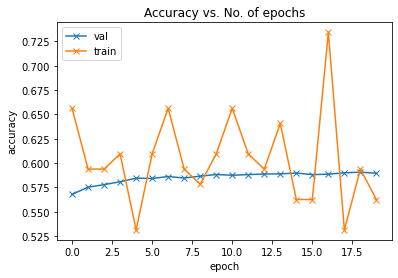

In [ ]:
plot_accuracies(history)

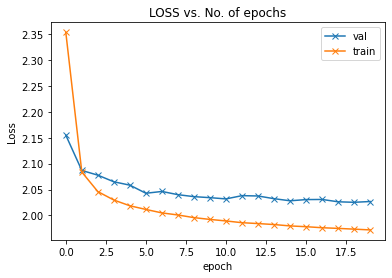

In [ ]:
plot_loss(history)

In [ ]:
history += fit(30, lr, model, train_loader, val_loader, opt_func)

tensor(0.6250)
Epoch [0], train_loss: 1.9710, train_acc: 0.6250, val_loss: 2.0299, val_acc: 0.5895
tensor(0.6094)
Epoch [1], train_loss: 1.9697, train_acc: 0.6094, val_loss: 2.0299, val_acc: 0.5882
tensor(0.5781)
Epoch [2], train_loss: 1.9695, train_acc: 0.5781, val_loss: 2.0292, val_acc: 0.5893
tensor(0.5625)
Epoch [3], train_loss: 1.9690, train_acc: 0.5625, val_loss: 2.0324, val_acc: 0.5895
tensor(0.6562)
Epoch [4], train_loss: 1.9676, train_acc: 0.6562, val_loss: 2.0252, val_acc: 0.5901
tensor(0.4219)
Epoch [5], train_loss: 1.9671, train_acc: 0.4219, val_loss: 2.0274, val_acc: 0.5912
tensor(0.5938)
Epoch [6], train_loss: 1.9649, train_acc: 0.5938, val_loss: 2.0278, val_acc: 0.5898
tensor(0.6875)
Epoch [7], train_loss: 1.9648, train_acc: 0.6875, val_loss: 2.0252, val_acc: 0.5911
tensor(0.6094)
Epoch [8], train_loss: 1.9646, train_acc: 0.6094, val_loss: 2.0258, val_acc: 0.5917
tensor(0.7344)
Epoch [9], train_loss: 1.9634, train_acc: 0.7344, val_loss: 2.0249, val_acc: 0.5906
tensor(0.5

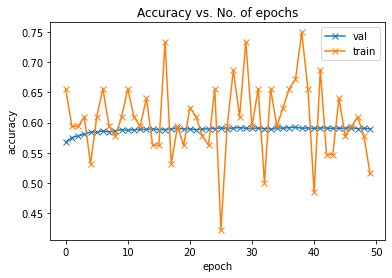

In [ ]:
plot_accuracies(history)

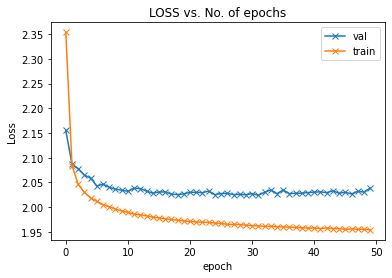

In [ ]:
plot_loss(history)

In [ ]:
#Building the CNN model2
class CNN2(ImageClassificationBase):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 7)
        self.conv2 = nn.Conv2d(in_channels = 10, out_channels = 20, kernel_size = 5) # output size after 2 maxpool = (20,17,17)
        self.fc1 = nn.Linear(5120 ,50)
        # self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2,stride = 1)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, stride = 1)
        
        x = torch.flatten(x, 1)
        # print(x.shape)

        x = self.fc1(x)
        x = F.relu(x)
        # x = self.dropout2(x)
        # x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
model_2 = CNN2()

In [ ]:
to_device(model_2, device)

CNN2(
  (conv1): Conv2d(1, 10, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=5120, out_features=50, bias=True)
)

In [ ]:
history_2 = []

In [ ]:
history_2 += fit(10, lr, model_2, train_loader, val_loader, opt_func)

tensor(0.7969)
Epoch [0], train_loss: 0.9604, train_acc: 0.7969, val_loss: 0.8149, val_acc: 0.7976
tensor(0.8906)
Epoch [1], train_loss: 0.8108, train_acc: 0.8906, val_loss: 0.7924, val_acc: 0.8027
tensor(0.8438)
Epoch [2], train_loss: 0.7918, train_acc: 0.8438, val_loss: 0.7885, val_acc: 0.8024
tensor(0.7969)
Epoch [3], train_loss: 0.7820, train_acc: 0.7969, val_loss: 0.7859, val_acc: 0.8034
tensor(0.8438)
Epoch [4], train_loss: 0.7754, train_acc: 0.8438, val_loss: 0.7819, val_acc: 0.8035
tensor(0.8125)
Epoch [5], train_loss: 0.7706, train_acc: 0.8125, val_loss: 0.7789, val_acc: 0.8039
tensor(0.8594)
Epoch [6], train_loss: 0.7687, train_acc: 0.8594, val_loss: 0.7776, val_acc: 0.8043
tensor(0.7969)
Epoch [7], train_loss: 0.7644, train_acc: 0.7969, val_loss: 0.7768, val_acc: 0.8055
tensor(0.8750)
Epoch [8], train_loss: 0.7603, train_acc: 0.8750, val_loss: 0.7824, val_acc: 0.8048
tensor(0.8125)
Epoch [9], train_loss: 0.7594, train_acc: 0.8125, val_loss: 0.7875, val_acc: 0.8034


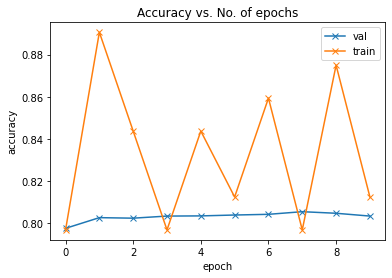

In [ ]:
plot_accuracies(history_2)

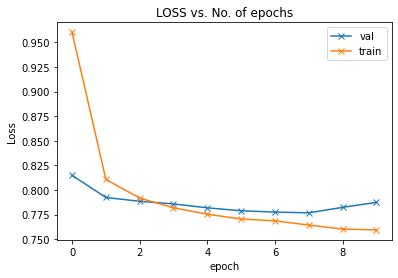

In [ ]:
plot_loss(history_2)

In [ ]:
history_2 += fit(10, lr, model_2, train_loader, val_loader, opt_func)

tensor(0.7656)
Epoch [0], train_loss: 0.7580, train_acc: 0.7656, val_loss: 0.7854, val_acc: 0.8041
tensor(0.8125)
Epoch [1], train_loss: 0.7556, train_acc: 0.8125, val_loss: 0.7825, val_acc: 0.8049
tensor(0.8125)
Epoch [2], train_loss: 0.7535, train_acc: 0.8125, val_loss: 0.7854, val_acc: 0.8044
tensor(0.7500)
Epoch [3], train_loss: 0.7526, train_acc: 0.7500, val_loss: 0.8007, val_acc: 0.8026
tensor(0.6562)
Epoch [4], train_loss: 0.7549, train_acc: 0.6562, val_loss: 0.7894, val_acc: 0.8044
tensor(0.7969)
Epoch [5], train_loss: 0.7515, train_acc: 0.7969, val_loss: 0.7945, val_acc: 0.8037
tensor(0.8750)
Epoch [6], train_loss: 0.7532, train_acc: 0.8750, val_loss: 0.7997, val_acc: 0.8034
tensor(0.7812)
Epoch [7], train_loss: 0.7521, train_acc: 0.7812, val_loss: 0.8036, val_acc: 0.8042
tensor(0.8125)
Epoch [8], train_loss: 0.7510, train_acc: 0.8125, val_loss: 0.7990, val_acc: 0.8048
tensor(0.8281)
Epoch [9], train_loss: 0.7490, train_acc: 0.8281, val_loss: 0.7968, val_acc: 0.8055


In [ ]:
history_2 += fit(5, 0.00001, model_2, train_loader, val_loader, opt_func)

tensor(0.7812)
Epoch [0], train_loss: 0.7463, train_acc: 0.7812, val_loss: 0.7941, val_acc: 0.8053
tensor(0.8750)
Epoch [1], train_loss: 0.7453, train_acc: 0.8750, val_loss: 0.7937, val_acc: 0.8052
tensor(0.8594)
Epoch [2], train_loss: 0.7448, train_acc: 0.8594, val_loss: 0.7926, val_acc: 0.8052
tensor(0.8750)
Epoch [3], train_loss: 0.7445, train_acc: 0.8750, val_loss: 0.7923, val_acc: 0.8052
tensor(0.7812)
Epoch [4], train_loss: 0.7443, train_acc: 0.7812, val_loss: 0.7918, val_acc: 0.8055


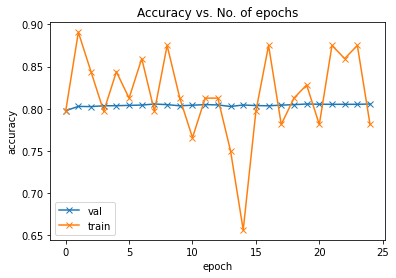

In [ ]:
plot_accuracies(history_2)

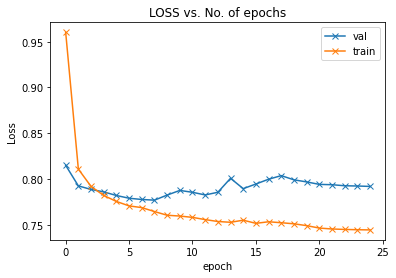

In [ ]:
plot_loss(history_2)

In [ ]:
# savig model 1 and loding model 1
# torch.save(model.state_dict(), 'setup1_model_1.pth')   # save the model
torch.save(model_2.state_dict(), 'setup_1_model_2.pth')   # save the model
# model2 = to_device(Cnn(), device)
# model2.load_state_dict(torch.load('cifar10-cnn.pth'))

In [ ]:
# model 3 for setup1
model_3 = CNN2()
model_3 = to_device(model_3,device)
device

device(type='cuda')

In [ ]:
optimizer = optim.Adadelta
history_3 = []

In [ ]:
history_3 =  fit(10, 0.1, model_3, train_loader, val_loader, opt_func=optimizer)

tensor(0.9375)
Epoch [0], train_loss: 0.9619, train_acc: 0.9375, val_loss: 0.1530, val_acc: 0.9551
tensor(0.9844)
Epoch [1], train_loss: 0.1097, train_acc: 0.9844, val_loss: 0.0930, val_acc: 0.9757
tensor(1.)
Epoch [2], train_loss: 0.0811, train_acc: 1.0000, val_loss: 0.0775, val_acc: 0.9790
tensor(1.)
Epoch [3], train_loss: 0.0673, train_acc: 1.0000, val_loss: 0.0734, val_acc: 0.9795
tensor(1.)
Epoch [4], train_loss: 0.0594, train_acc: 1.0000, val_loss: 0.0639, val_acc: 0.9818
tensor(0.9531)
Epoch [5], train_loss: 0.0535, train_acc: 0.9531, val_loss: 0.0628, val_acc: 0.9833
tensor(1.)
Epoch [6], train_loss: 0.0485, train_acc: 1.0000, val_loss: 0.0600, val_acc: 0.9840
tensor(0.9688)
Epoch [7], train_loss: 0.0452, train_acc: 0.9688, val_loss: 0.0666, val_acc: 0.9813
tensor(1.)
Epoch [8], train_loss: 0.0423, train_acc: 1.0000, val_loss: 0.0569, val_acc: 0.9850
tensor(0.9844)
Epoch [9], train_loss: 0.0398, train_acc: 0.9844, val_loss: 0.0590, val_acc: 0.9820


In [ ]:
history_3 +=  fit(5, 0.1, model_3, train_loader, val_loader, opt_func=optimizer)

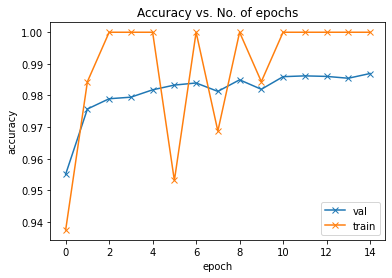

In [ ]:
plot_accuracies(history_3)


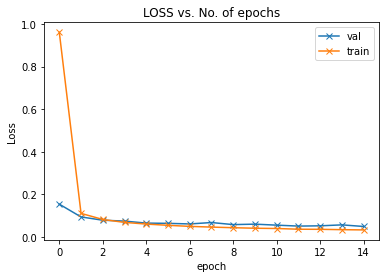

In [ ]:
plot_loss(history_3)

In [ ]:
evaluate(model_3, test_loader)

{'val_loss': 0.03273046016693115, 'val_acc': 0.9897491931915283}

In [ ]:
# saving model 3 as best model
torch.save(model_3.state_dict(), 'setup_1_bestmodel.pth')   # save the model

## part 3 setup2


In [ ]:
class setup_2_CNN(ImageClassificationBase):
    def __init__(self):
        super(setup_2_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=2)
        self.residual_conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=0)  # residual connection
        self.fc1 = nn.Linear(8820, 50)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        # print(x.shape,"first cov layer")
        x = F.max_pool2d(x, 2, stride=1 ) # max pooling size 
        # print(x.shape , "first maxpol layer")

        residual = x  # store the input to conv2 for residual connection 12,12
        x = self.conv2(x)
        # print(x.shape , "second conv layer")
        x = F.relu(x)
        x = F.max_pool2d(x, 2, stride=1 ) # max pooling size
        # print(x.shape, "second maxpol layer")
       

        residual = self.residual_conv2(residual) # apply residual connection 12 12
        # print(residual.shape)
        # print(x.shape)
        x += residual  # add residual to output of conv2
        x = F.relu(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)

        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
setup2_model = setup_2_CNN()
setup2_model

Lodaing model to gpu 

In [ ]:
to_device(setup2_model, device)

In [ ]:
opt_func = torch.optim.Adam

In [ ]:
setup_2_his = []


In [ ]:
setup_2_his =  fit(10, 0.001, setup2_model, train_loader, val_loader, opt_func)

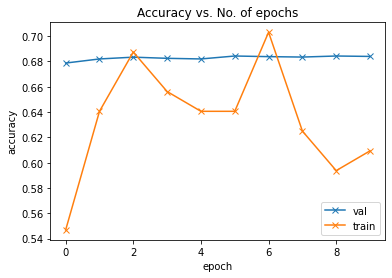

In [ ]:
plot_accuracies(setup_2_his)

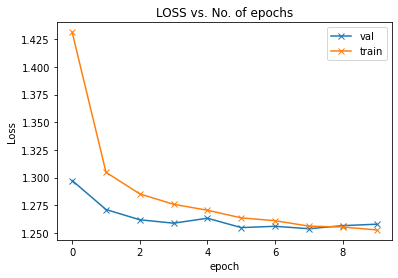

In [ ]:
plot_loss(setup_2_his)

In [ ]:
setup_2_his +=  fit(10, 0.001, setup2_model, train_loader, val_loader, opt_func)

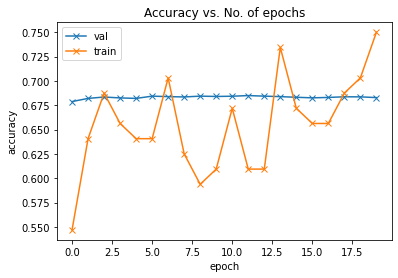

In [ ]:
plot_accuracies(setup_2_his)

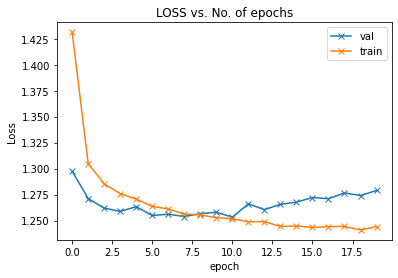

In [ ]:
plot_loss(setup_2_his)

In [ ]:
# savig model 1 and loding model 1
# torch.save(model.state_dict(), 'setup1_model_1.pth')   # save the model
torch.save(setup2_model.state_dict(), 'setup2_model.pth')   # save the model
# model2 = to_device(Cnn(), device)
# model2.load_state_dict(torch.load('cifar10-cnn.pth'))

In [ ]:
setup_2_his +=  fit(30, 0.001, setup2_model, train_loader, val_loader, opt_func)

tensor(0.5938)
Epoch [0], train_loss: 1.2437, train_acc: 0.5938, val_loss: 1.2944, val_acc: 0.6824
tensor(0.6719)
Epoch [1], train_loss: 1.2427, train_acc: 0.6719, val_loss: 1.2651, val_acc: 0.6847
tensor(0.6094)
Epoch [2], train_loss: 1.2401, train_acc: 0.6094, val_loss: 1.2883, val_acc: 0.6817
tensor(0.7344)
Epoch [3], train_loss: 1.2430, train_acc: 0.7344, val_loss: 1.2747, val_acc: 0.6831
tensor(0.7344)
Epoch [4], train_loss: 1.2382, train_acc: 0.7344, val_loss: 1.2685, val_acc: 0.6857
tensor(0.6875)
Epoch [5], train_loss: 1.2379, train_acc: 0.6875, val_loss: 1.3001, val_acc: 0.6836
tensor(0.7031)
Epoch [6], train_loss: 1.2470, train_acc: 0.7031, val_loss: 1.2759, val_acc: 0.6835
tensor(0.7031)
Epoch [7], train_loss: 1.2423, train_acc: 0.7031, val_loss: 1.2822, val_acc: 0.6843
tensor(0.5469)
Epoch [8], train_loss: 1.2395, train_acc: 0.5469, val_loss: 1.2858, val_acc: 0.6839
tensor(0.6250)
Epoch [9], train_loss: 1.2405, train_acc: 0.6250, val_loss: 1.2834, val_acc: 0.6835
tensor(0.7

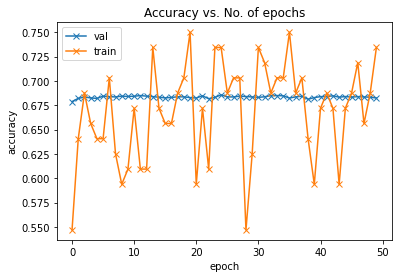

In [ ]:
plot_accuracies(setup_2_his)

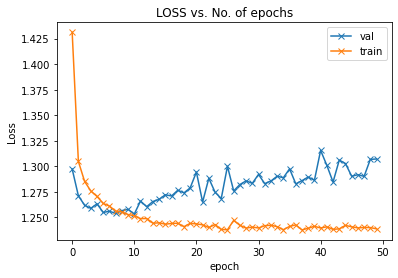

In [ ]:
plot_loss(setup_2_his)

In [ ]:
# savig model 1 and loding model 1
# torch.save(model.state_dict(), 'setup1_model_1.pth')   # save the model
torch.save(setup2_model.state_dict(), 'setup2_model_after60.pth')   # save the model
# model2 = to_device(Cnn(), device)
# model2.load_state_dict(torch.load('cifar10-cnn.pth'))

# Q3 : Augmentations

In [ ]:
train_data_subset = torch.utils.data.Subset(train_data, torch.randint(0, len(train_data), size=(int(len(train_data)*0.2),)))
#Part A
lr_flip = transforms.RandomHorizontalFlip(p=1)

# Apply transformation to train_data_subset
train_data_subset_lr_flipped = []
for image, label in train_data_subset:
    train_data_subset_lr_flipped.append((lr_flip(image), label))
# Concatenate the original train data with the augmented data
train_data_lr = torch.utils.data.ConcatDataset([train_data, train_data_subset_lr_flipped])



In [ ]:
#Part B
rotate = transforms.RandomRotation(degrees=30)

# Apply transformation to train_data_subset
train_data_subset_rotated = []
for image, label in train_data_subset:
    train_data_subset_rotated.append((rotate(image), label))
# Concatenate the original train data with the augmented data
train_data_rotated = torch.utils.data.ConcatDataset([train_data, train_data_subset_rotated])


In [ ]:
#Part C
gaussian = transforms.GaussianBlur(kernel_size=3)

# Apply transformation to train_data_subset
train_data_subset_gaussiand = []
for image, label in train_data_subset:
    train_data_subset_gaussiand.append((gaussian(image), label))
# Concatenate the original train data with the augmented data
train_data_gaussiand = torch.utils.data.ConcatDataset([train_data, train_data_subset_gaussiand])


In [ ]:
#Part D
#Combine all the augmentations
positional_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomRotation(degrees=30),
    transforms.GaussianBlur(kernel_size=3)
])

# Apply positional augmentation to the train data subset
positional_augmented_data = []
for image, label in train_data_subset:
    positional_augmented_data.append((positional_transforms(image), label))

# Concatenate original train data with positional augmented data
train_data_combined = torch.utils.data.ConcatDataset([train_data, positional_augmented_data])

In [ ]:
#model initialization
num_epochs = 20
opt_func = torch.optim.Adadelta
lr = 0.01

model_1 = CNN()

#loading the dataset into dataloaders
# train = {"Left-Right Flip": train_data_lr, "Rotated Images": train_data_rotated, "Noise filled Images": train_data_gaussiand, "Final data": train_data_combined}
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
# val_loader = DeviceDataLoader(val_loader, device)
# test_loader = DeviceDataLoader(test_loader, device)

history = []
# #Training for each data augmentations
# for label, training_data in train.items():
#   #load the datasets into dataloaders
#   print(f"Dataset: {label}") 
#   train_loader = DataLoader(training_data, batch_size=64, shuffle=True)
#   train_loader = DeviceDataLoader(training_data, device)
#   model_1 = CNN2()
#   model_1 = to_device(model_1, device)
#   history = fit(20, lr, model_1, train_loader, val_loader, opt_func)
#   plot_accuracies(history)
#   plot_loss(history)







In [ ]:
# train_loader = DeviceDataLoader(train_data_lr, device)
# model_1 = to_device(model_1, device)
train_data_lr = DataLoader(train_data_lr, batch_size=64, shuffle=True)
history = fit(20, lr, model_1, train_data_lr, val_loader, opt_func)



tensor(0.6875)
Epoch [0], train_loss: 1.5437, train_acc: 0.6875, val_loss: 1.3522, val_acc: 0.6646
tensor(0.6562)
Epoch [1], train_loss: 1.3971, train_acc: 0.6562, val_loss: 1.3313, val_acc: 0.6704
tensor(0.5156)
Epoch [2], train_loss: 1.3859, train_acc: 0.5156, val_loss: 1.3569, val_acc: 0.6651
tensor(0.6250)
Epoch [3], train_loss: 1.3783, train_acc: 0.6250, val_loss: 1.3559, val_acc: 0.6665
tensor(0.7656)
Epoch [4], train_loss: 1.3772, train_acc: 0.7656, val_loss: 1.3219, val_acc: 0.6730
tensor(0.7500)
Epoch [5], train_loss: 1.3679, train_acc: 0.7500, val_loss: 1.3215, val_acc: 0.6720
tensor(0.7031)
Epoch [6], train_loss: 1.3744, train_acc: 0.7031, val_loss: 1.3250, val_acc: 0.6700
tensor(0.5469)
Epoch [7], train_loss: 1.3640, train_acc: 0.5469, val_loss: 1.3267, val_acc: 0.6717
tensor(0.6094)
Epoch [8], train_loss: 1.3694, train_acc: 0.6094, val_loss: 1.3354, val_acc: 0.6695


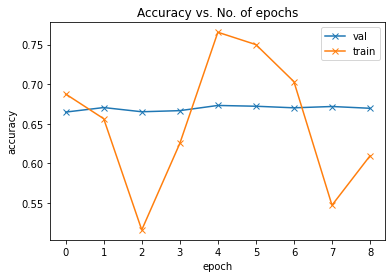

In [ ]:
plot_accuracies(history)

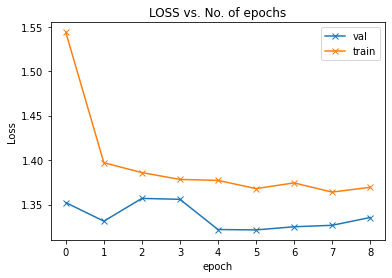

In [ ]:
plot_loss(history)

tensor(0.6406)
Epoch [0], train_loss: 1.3469, train_acc: 0.6406, val_loss: 1.3190, val_acc: 0.6719
tensor(0.5938)
Epoch [1], train_loss: 1.3323, train_acc: 0.5938, val_loss: 1.3331, val_acc: 0.6686
tensor(0.6719)
Epoch [2], train_loss: 1.3237, train_acc: 0.6719, val_loss: 1.2772, val_acc: 0.6784
tensor(0.5781)
Epoch [3], train_loss: 1.3268, train_acc: 0.5781, val_loss: 1.3009, val_acc: 0.6754
tensor(0.7188)
Epoch [4], train_loss: 1.3259, train_acc: 0.7188, val_loss: 1.3026, val_acc: 0.6740
tensor(0.8438)
Epoch [5], train_loss: 1.3195, train_acc: 0.8438, val_loss: 1.2944, val_acc: 0.6758
tensor(0.7188)
Epoch [6], train_loss: 1.3221, train_acc: 0.7188, val_loss: 1.2918, val_acc: 0.6744
tensor(0.8438)
Epoch [7], train_loss: 1.3223, train_acc: 0.8438, val_loss: 1.2738, val_acc: 0.6786
tensor(0.6406)
Epoch [8], train_loss: 1.3241, train_acc: 0.6406, val_loss: 1.3016, val_acc: 0.6743
tensor(0.7031)
Epoch [9], train_loss: 1.3138, train_acc: 0.7031, val_loss: 1.3020, val_acc: 0.6756
tensor(0.7

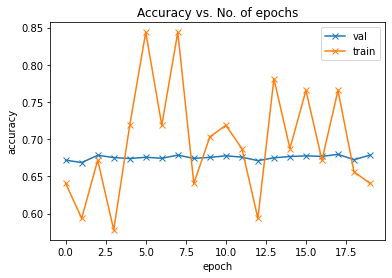

In [ ]:
train_data_rotated = DataLoader(train_data_rotated, batch_size=64, shuffle=True)
history = fit(20, lr, model_1, train_data_rotated, val_loader, opt_func)
plot_accuracies(history)


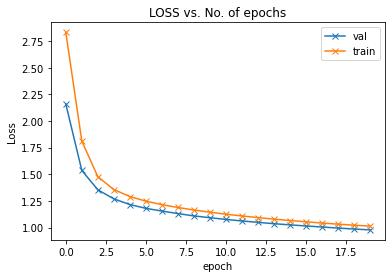

In [ ]:
plot_loss(history)


tensor(0.7969)
Epoch [0], train_loss: 0.9774, train_acc: 0.7969, val_loss: 0.9692, val_acc: 0.8300
tensor(0.7969)
Epoch [1], train_loss: 0.9690, train_acc: 0.7969, val_loss: 0.9628, val_acc: 0.8307
tensor(0.7969)
Epoch [2], train_loss: 0.9622, train_acc: 0.7969, val_loss: 0.9567, val_acc: 0.8310
tensor(0.8125)
Epoch [3], train_loss: 0.9558, train_acc: 0.8125, val_loss: 0.9496, val_acc: 0.8371
tensor(0.8438)
Epoch [4], train_loss: 0.9500, train_acc: 0.8438, val_loss: 0.9450, val_acc: 0.8404
tensor(0.7031)
Epoch [5], train_loss: 0.9447, train_acc: 0.7031, val_loss: 0.9390, val_acc: 0.8421
tensor(0.7969)
Epoch [6], train_loss: 0.9398, train_acc: 0.7969, val_loss: 0.9333, val_acc: 0.8419
tensor(0.8594)
Epoch [7], train_loss: 0.9352, train_acc: 0.8594, val_loss: 0.9296, val_acc: 0.8452
tensor(0.8906)
Epoch [8], train_loss: 0.9310, train_acc: 0.8906, val_loss: 0.9284, val_acc: 0.8447
tensor(0.8281)
Epoch [9], train_loss: 0.9271, train_acc: 0.8281, val_loss: 0.9247, val_acc: 0.8469
tensor(0.8

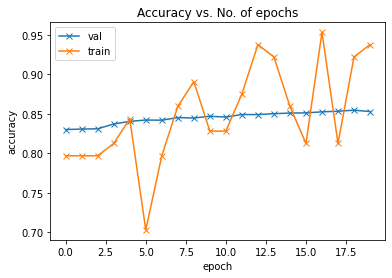

In [ ]:
train_data_gaussiand = DataLoader(train_data_gaussiand, batch_size=64, shuffle=True)
history = fit(20, lr, model_1, train_data_gaussiand, val_loader, opt_func)
plot_accuracies(history)


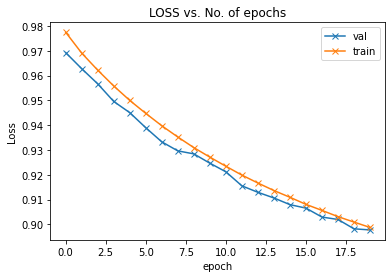

In [ ]:
plot_loss(history)


tensor(0.8281)
Epoch [0], train_loss: 1.2379, train_acc: 0.8281, val_loss: 0.9122, val_acc: 0.8541
tensor(0.8125)
Epoch [1], train_loss: 1.1794, train_acc: 0.8125, val_loss: 0.9162, val_acc: 0.8508
tensor(0.8750)
Epoch [2], train_loss: 1.1492, train_acc: 0.8750, val_loss: 0.9178, val_acc: 0.8478
tensor(0.8594)
Epoch [3], train_loss: 1.1320, train_acc: 0.8594, val_loss: 0.9218, val_acc: 0.8471
tensor(0.8125)
Epoch [4], train_loss: 1.1210, train_acc: 0.8125, val_loss: 0.9250, val_acc: 0.8477
tensor(0.8906)
Epoch [5], train_loss: 1.1127, train_acc: 0.8906, val_loss: 0.9250, val_acc: 0.8479
tensor(0.8594)
Epoch [6], train_loss: 1.1065, train_acc: 0.8594, val_loss: 0.9253, val_acc: 0.8482
tensor(0.7969)
Epoch [7], train_loss: 1.1012, train_acc: 0.7969, val_loss: 0.9282, val_acc: 0.8471
tensor(0.7969)
Epoch [8], train_loss: 1.0968, train_acc: 0.7969, val_loss: 0.9256, val_acc: 0.8470
tensor(0.7188)
Epoch [9], train_loss: 1.0927, train_acc: 0.7188, val_loss: 0.9277, val_acc: 0.8472
tensor(0.8

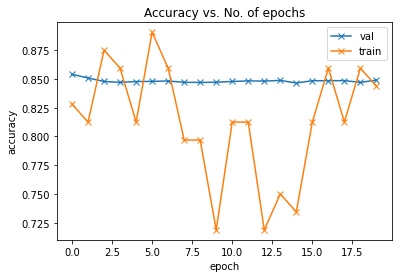

In [ ]:
train_data_combined = DataLoader(train_data_combined, batch_size=64, shuffle=True)
history = fit(20, lr, model_1, train_data_combined, val_loader, opt_func)
plot_accuracies(history)


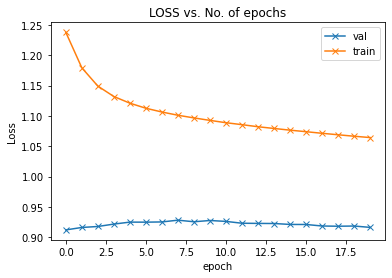

In [ ]:
plot_loss(history)
